<a href="https://colab.research.google.com/github/WeilongYE/unet-for-cityscapes-road-segmentation/blob/main/unet_for_cityscapes_road_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet for Cityscapes Road Segmentation

## Import datasets from Kaggle

In [10]:
import os
import shutil
import zipfile

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [7]:
datasets_dir = "datasets"
if os.path.exists(datasets_dir):
  shutil.rmtree(datasets_dir)

# Get the Kaggle API Key. https://www.kaggle.com/docs/api#authentication
# - Go to Kaggle and log in.
# - Click on your profile picture (top right), then select Settings.
# - Scroll down to the API section and click Create New API Token.
# - A file named kaggle.json will be downloaded.
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

# Move kaggle key to proper location
os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)

# Install Kaggle API and Download the Datasets
!pip install kaggle
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

# Extract the Datasets
with zipfile.ZipFile("cityscapes-image-pairs.zip", "r") as zip_ref:
    zip_ref.extractall(datasets_dir)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs
License(s): other
 93% 188M/202M [00:01<00:00, 165MB/s]
100% 202M/202M [00:01<00:00, 158MB/s]


## Data Preparation

### Data Inspection

### General Info

Number of train examples: 2975
Number of val examples: 500


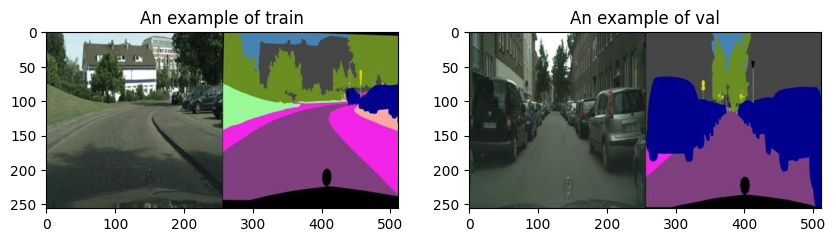

shape of examples (height, width): (256, 512, 3)


In [21]:
orig_train_dir = os.path.join(datasets_dir, "cityscapes_data/train")
orig_val_dir = os.path.join(datasets_dir, "cityscapes_data/val")

# Number of examples
orig_train_filenames = os.listdir(orig_train_dir)
orig_val_filenames = os.listdir(orig_val_dir)
print(f"Number of train examples: {len(orig_train_filenames)}")
print(f"Number of val examples: {len(orig_val_filenames)}")

# Display an image from 'train' and an image from 'val'
image_train = Image.open(os.path.join(orig_train_dir, orig_train_filenames[0]))
image_val = Image.open(os.path.join(orig_val_dir, orig_val_filenames[0]))
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].set_title("An example of train")
axis[0].imshow(image_train)
axis[1].set_title("An example of val")
axis[1].imshow(image_val)
plt.show()

# Shape of examples
print(f"shape of examples (height, width): {np.array(image_train).shape}")

### Label Info
Based on the info [here](https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py). The color of road is (128, 64, 128)
.
Try to use this color to extract road.

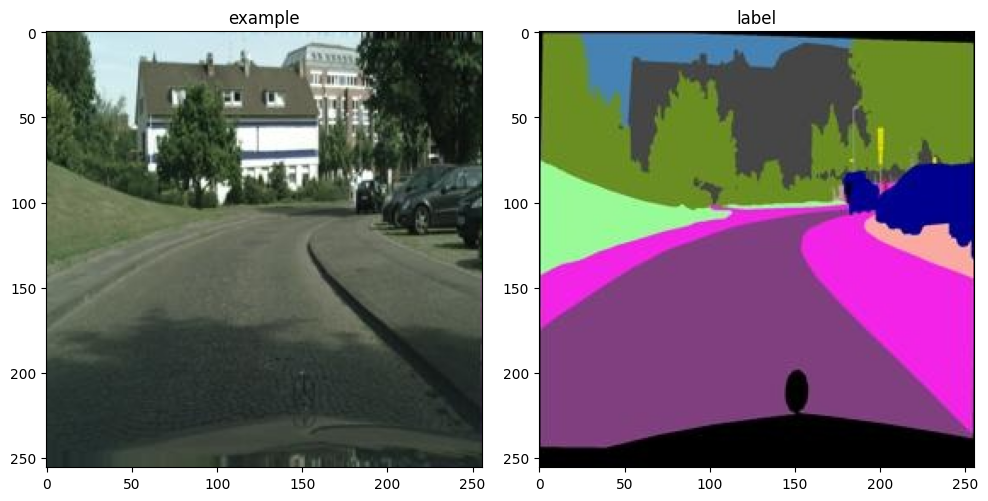

In [25]:
# Split out colored label image from original image
image_train = np.array(image_train)
h,w,_ = image_train.shape
x = image_train[:, :w//2, :]
y = image_train[:, w//2:, :]
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(x)
axis[0].set_title("example")
axis[1].imshow(y)
axis[1].set_title("label")
plt.tight_layout()
plt.show()

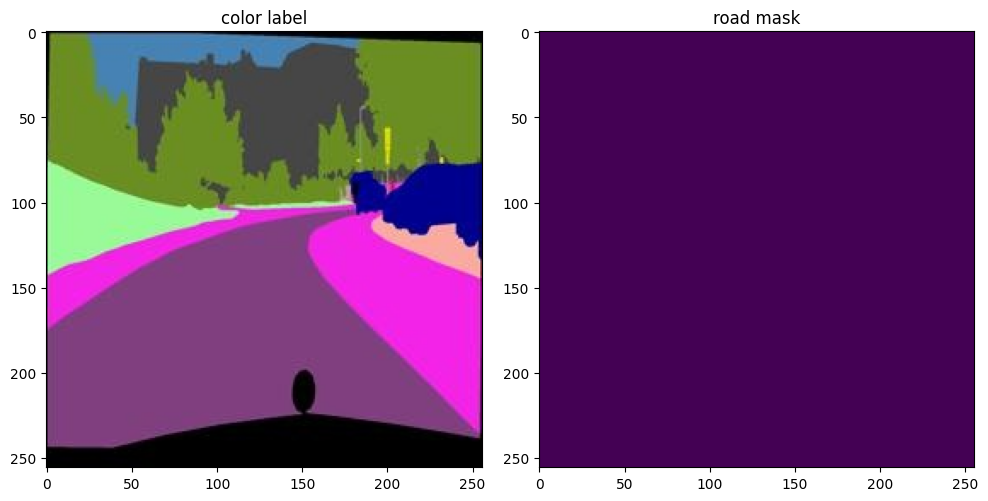

In [32]:
# Extract road binary mask based on the road color
road_color = (128, 64, 128)
road_mask = np.all(y == road_color, axis=-1).astype(np.uint8)
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(y)
axis[0].set_title("color label")
axis[1].imshow(road_mask)
axis[1].set_title("road mask")
plt.tight_layout()
plt.show()


It showed that the road color label is not exactly (128,64,128)